# Two-level system tutorial

## Import

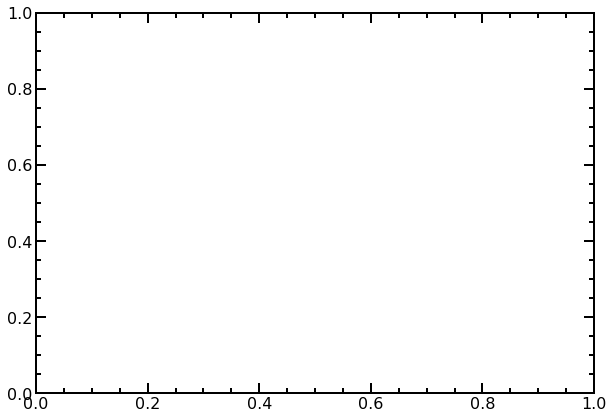

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
import scipy.linalg

## Bloch sphere

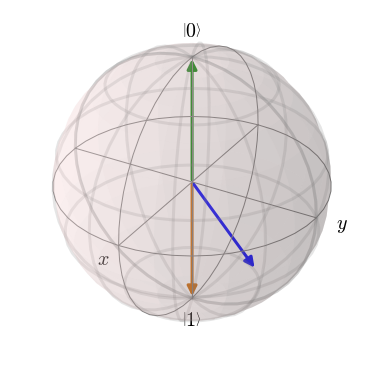

In [96]:
psi0 = basis(2,0)
psi1 = basis(2,1)
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
b = Bloch()
b.add_states([psi0,psi1,psi])
b.make_sphere()

## State tomography

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.40909091+0.j         0.27272727-0.40909091j]
 [0.27272727+0.40909091j 0.59090909+0.j        ]]


<Figure size 504x504 with 0 Axes>

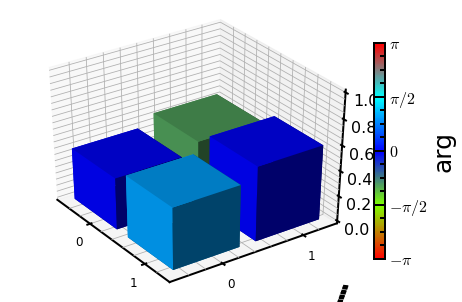

In [97]:
#State tomography
plt.figure(figsize=[7,7])
rho = ket2dm(psi)
matrix_histogram_complex(rho)
print (rho)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fc0a9639490>)

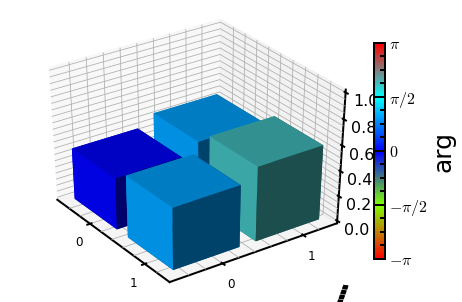

In [98]:
#Can also define matrices
psi0 = np.matrix([1,0]).transpose()
psi1 = np.matrix([0,1]).transpose()
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
# psi = Qobj(psi)
# rho = ket2dm(psi)
#or
rho = psi*psi.transpose()
rho = Qobj(rho)
matrix_histogram_complex(rho)

## Quantum fidelity

See http://qutip.org/docs/4.0.2/modules/qutip/metrics.html

Definition: 

a. State fidelity
$$ \mathcal{F}(\rho,\sigma)=\left(\mathrm{Tr}\sqrt{\rho^{1/2}\sigma\rho^{1/2}} \right)^2$$
from which the fidelity between a pure state $|\psi \rangle$ and an arbitrary state $\rho$ can be written as
$$\mathcal{F}(\rho,\psi)=\sqrt{\langle\psi |\rho |\psi\rangle}$$

b. Process fidelity

If the $\chi$ matrix is known, then the fidelity to the ideal state $\chi'$ is 
$$ \mathcal{F}(\chi,\chi')=\left(\mathrm{Tr}\sqrt{\chi^{1/2}\chi '\chi^{1/2}} \right)^2$$

From Pedersen et al., the fidelity between two unitary operations $U$ and $U_o$ is
$$\mathcal{F}=\frac{1}{N(N+1)}\left[\mathrm{Tr}(MM^\dagger) + |\mathrm{Tr}(M)|^2 \right],$$
with $M=U_0^\dagger U$ and $N=2^n$ is the dimension of the Hilbert space

In [99]:
#Using qutip's built in fidelity functions
from qutip import fidelity
psi0 = basis(2,0)
psi1 = basis(2,1)
a=1
b=1
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
print("state fidelity between 0 and 1: ", fidelity(psi0,psi1))
print("state fidelity between 1 and 1:", fidelity(psi1,psi1))
print("state fidelity between 1 and superposition:", fidelity(psi1,psi))

from qutip.qip.operations import cnot
from qutip.qip.operations import csign
from qutip import process_fidelity
cz = csign()
iden = identity(4)
print("process fidelity between cz and cnot: ", process_fidelity(cz,cnot()))
print("process fidelity between cz and cz: ", process_fidelity(cz,cz))
# print("process fidelity between cz and I: ", process_fidelity(cz,iden))

#Or define it ourselves
rho0 = np.array([[1,0],[0,0]])
rho1 = np.array([[0,0],[0,1]])
rho = np.array([[1,1],[1,1]])/np.sqrt(2)


def state_fidelity_func(rho,rho_ideal):
    f = abs(np.trace(scipy.linalg.sqrtm(scipy.linalg.sqrtm(rho_ideal).dot(rho).dot(scipy.linalg.sqrtm(rho_ideal)))))
    return f**2

def process_fidelity_func(U,U_ideal,qubit_num):
    N = 2**qubit_num
    coeff = (N*(N+1))**-1.0
    M = np.conj(U_ideal.transpose()) * U
    f = np.trace(M*np.conj(M.transpose())) + np.trace(M)**2
    return coeff * f

print ('State fidelity as defined, 0 and 1: ', state_fidelity_func(rho0,rho1))    
print ('State fidelity as defined, 0 and 0: ',state_fidelity_func(rho0,rho0))    
print ('State fidelity as defined, 0 and superposition: ', state_fidelity_func(rho0,rho))    
U_cz = np.diag([1,1,1,-1])
U_cnot = np.diag([1,1,0,0])
U_cnot[2,3] = 1
U_cnot[3,2] = 1
U_iden = np.diag([1,1,1,1])
print("Defined process fidelity between cz and cnot: ", process_fidelity_func(U_cz,U_cnot, 2))
print("Defined process fidelity between cz and cz: ", process_fidelity_func(U_cz,U_cz, 2))


state fidelity between 0 and 1:  0.0
state fidelity between 1 and 1: 1.0
state fidelity between 1 and superposition: 0.7071067811865475
process fidelity between cz and cnot:  0.5
process fidelity between cz and cz:  1.0
State fidelity as defined, 0 and 1:  0.0
State fidelity as defined, 0 and 0:  1.0
State fidelity as defined, 0 and superposition:  0.7071067811865471
Defined process fidelity between cz and cnot:  0.30000000000000004
Defined process fidelity between cz and cz:  1.0


## Driving two-level system
Here, we define the two-level system via the Hamiltonian $$H=\frac{1}{2}\omega_a\sigma_Z$$ and the driving term 
$$H_d= g\cos(\omega_d t)\sigma_X$$
We can either solve the Schrodinger equation directly or use RWA to get the Hamiltonian in the rotating frame.

Text(0, 0.5, '$\\langle \\sigma_Z \\rangle$')

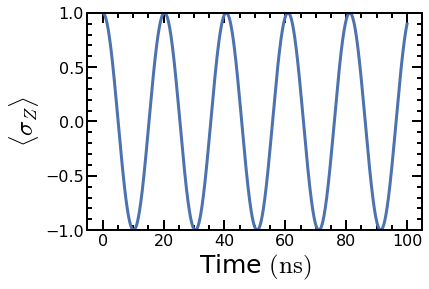

In [100]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()
    
# def H1_coeff(time,wd):
#     return np.cos(2*np.pi*wd*time)

tlist = np.linspace(0,100,2001)*1
H = [H0,[H1, np.cos(2*np.pi*drive_freq*tlist)]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist, sz)
# U_t = propagator(H, tlist,[])
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')

Text(0, 0.5, '$\\langle \\sigma_Z \\rangle$')

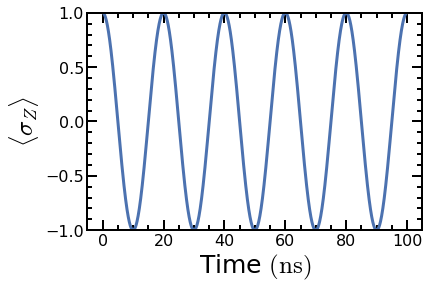

In [101]:
#Using RWA
H = 2*np.pi*0.5*(atom_freq-drive_freq)*sigmaz() + 2*np.pi*0.5*coupl_const*sigmax()
output = mesolve(H, rho0=basis(2,0),tlist = tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist,sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')

Above we assume a constant drive. Here, we assume that the drive can be shaped by using a modulated pulse. We can redefine the drive Hamiltonian as a product of the pulse and the carrier tone.

In [102]:
#Here we define a pulse that rotates the spin by 2pi
#Also define DRAG coefficient, which we will explore later
def H_gate_pulse(t, omega_d, DRAG, DRAG_coeff, shape, sigma, T_gate):
    """ 
    H_drive_coeff_gate = xi_x(t) cos(wt) + xi_y(t) sin(wt)
    Normalization: \int xi(t') dt'= 2\pi for 0 < t' < T_gate
    If DRAG == True: xi_y(t) = alpha * d xi_x / dt,
    else: xi_y = 0
    """ 
    two_pi_t = 2 * np.pi * t
    if DRAG:
        alpha = DRAG_coeff
    else:
        alpha = 0
    if shape == 'square':
        xi_x = 1 / T_gate
        xi_y = 0
    elif shape == 'gauss':
        sigma = sigma * T_gate
        integral_value = (np.sqrt(2 * np.pi) * sigma
                          * scipy.special.erf(
                    T_gate / (2 * np.sqrt(2) * sigma))
                          - T_gate * np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        coeff = 2 * np.pi / integral_value
        xi_x = coeff * (np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2)
                        - np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        xi_y = (alpha * coeff * (- (t - T_gate / 2) / sigma ** 2)
                * np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2))
    return (xi_x * np.cos(two_pi_t*omega_d)
            + xi_y * np.sin(two_pi_t*omega_d))

Text(0, 0.5, '$\\mathrm{\\langle \\sigma_Z \\rangle}$')

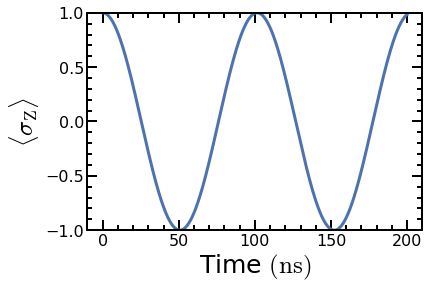

In [103]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 1 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()

tlist = np.linspace(0,200,2001) #ns
H = [H0,[H1, H_gate_pulse(tlist, omega_d = drive_freq, sigma = 0.25, T_gate = 100, DRAG = False, DRAG_coeff = 0, shape = "square")]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist, sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\mathrm{\langle \sigma_Z \rangle}$')

We can check the state fidelity during the drive

Text(0, 0.5, '$\\mathcal{F}(|0\\rangle)$')

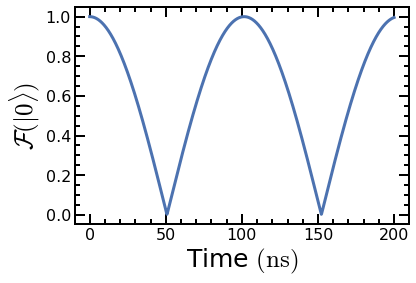

In [110]:
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=[])
states = output.states
fidelity_list = np.zeros(len(tlist))
for idx in range(len(tlist)):
    fidelity_list[idx] = fidelity(states[idx], basis(2,0))
plt.plot(tlist, fidelity_list)
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\mathcal{F}(|0\rangle)$')

### Gate fidelity

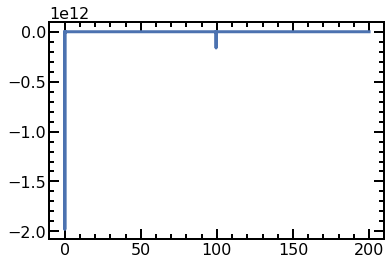

In [112]:
#for now, we can also check the gate fidelity
U_t = propagator(H, t=tlist)
U_ideal = identity(2)
fidel_array = np.zeros(len(tlist))
for idx in range(len(tlist)):
    fidel_array[idx] = process_fidelity(U_t[idx],U_t[idx])
plt.plot(tlist,fidel_array)
                            

## Coupled system

Text(0, 0.5, 'Transition freq')

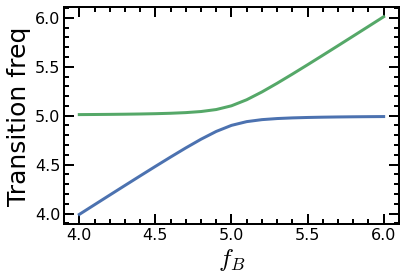

In [145]:
def coupled_tls_hamiltonian(wa,wb,g):
    sza = tensor(sigmaz(),qeye(2))
    sxa = tensor(sigmax(),qeye(2))
    szb = tensor(qeye(2), sigmaz())
    sxb = tensor(qeye(2), sigmax())
    return wa*sza/2 + wb*szb/2 + g*sxa*sxb

freq_a = 5
freq_b = np.linspace(4,6,21)
coupling = 0.1
energies = np.zeros((len(freq_b), 4))
for idx, wb in enumerate(freq_b):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,wb,coupling).eigenenergies()
for idy in range(1,3):
    plt.plot(freq_b, energies[:,idy]-energies[:,0])
plt.xlabel(r'$f_B$')
plt.ylabel('Transition freq')

Text(0, 0.5, '$\\delta f_{00-10}$')

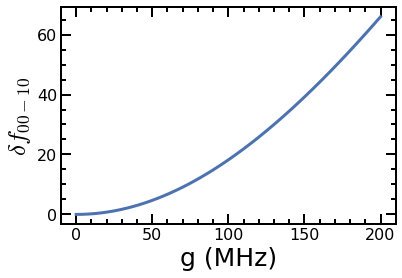

In [146]:
freq_a = 5
freq_b = 4.5
coupling = np.linspace(0,0.2)
energies = np.zeros((len(coupling), 4))
for idx, g in enumerate(coupling):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,freq_b,g).eigenenergies()
trans_freq = energies[:,1]   - energies[:,0]
trans_freq = abs(trans_freq - np.max(trans_freq))
plt.plot(coupling*1e3, trans_freq*1e3)
plt.xlabel('g (MHz)')
plt.ylabel(r'$\delta f_{00-10}$')

## Three level system

In [8]:
def hamiltonian_3ls(w,alpha):
    m = np.diag([0.0,1.0,1.0])
    m[1,1] = w
    m[2,2] = w-alpha
    return Qobj(m)

def sigma_3ls():
    m = np.diag(np.ones(2),1) + np.diag(np.ones(2),-1)
    return Qobj(m)
print (hamiltonian_3ls(5,0.2))
print (sigma_3ls())

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.  0.  0. ]
 [0.  5.  0. ]
 [0.  0.  4.8]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


In [9]:
energies = hamiltonian_3ls(5,0.2).eigenenergies()
print (energies)

[0.  4.8 5. ]
